In [1]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline

In [2]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    for _ in range(size_of_mini_batch):
        d = random.choice(train_data)
        inputs  = np.append(inputs, d)
    inputs  = inputs.reshape(-1, length_of_sequences)
    return inputs

In [3]:
#''' pred area judgement from rssi
data_path                   = './input/data.csv'
num_of_sequence_length      = 10
num_of_hidden_nodes         = 20
num_of_training_epochs      = 100
size_of_mini_batch          = 10
size_of_test_batch          = 4
learning_rate               = 0.02
train_dir                   = 'train'

In [4]:
data = np.loadtxt(data_path, delimiter=",", skiprows=1, dtype=np.float32)
train_data = data[[np.where((data[:, 1] == 1))],3:].reshape(-1, num_of_sequence_length)
print(train_data)
test_data = data[[np.where((data[:, 0] == 2) & (data[:, 1] == 0) & (data[:, 2] == 0))],3:].reshape(-1, num_of_sequence_length)
print(test_data)
train_data *= -0.01
test_data *= -0.01

[[-50. -50. -50. -51. -49. -47. -45. -44. -45. -49.]
 [-53. -53. -53. -53. -51. -50. -50. -51. -52. -52.]
 [-54. -54. -54. -53. -52. -50. -48. -48. -47. -46.]
 [-49. -47. -46. -45. -44. -44. -42. -41. -41. -41.]
 [-51. -49. -47. -46. -44. -43. -43. -46. -51. -53.]
 [-51. -52. -52. -51. -49. -49. -51. -50. -48. -49.]
 [-47. -44. -42. -39. -38. -38. -38. -37. -38. -38.]
 [-49. -46. -44. -41. -39. -39. -39. -40. -43. -46.]
 [-57. -56. -54. -51. -48. -48. -49. -51. -53. -52.]
 [-56. -58. -60. -60. -58. -55. -55. -54. -53. -52.]
 [-58. -56. -54. -53. -53. -53. -50. -48. -48. -49.]
 [-53. -54. -55. -53. -51. -49. -50. -48. -45. -46.]
 [-55. -52. -50. -51. -48. -44. -43. -44. -45. -46.]
 [-58. -60. -61. -59. -56. -55. -56. -54. -50. -52.]
 [-60. -57. -56. -58. -60. -57. -52. -49. -48. -48.]
 [-56. -53. -51. -52. -53. -52. -48. -45. -42. -43.]
 [-57. -57. -54. -52. -53. -54. -51. -48. -47. -46.]
 [-58. -55. -52. -52. -54. -54. -52. -49. -48. -47.]
 [-48. -48. -49. -49. -50. -48. -46. -44. -42.

In [5]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [6]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    with tf.name_scope("inference") as scope:
        weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")

        hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
        output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(init)
        accuracy_results = []
        
        for epoch in range(num_of_training_epochs):
            data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: size_of_mini_batch,
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 2 == 0:
                train_loss = sess.run(loss_op, feed_dict=train_dict)
                
                # eval accuracy
                data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
                pred_dict = {
                    input_ph:      data,
                    supervisor_ph: data,
                    batch_size_ph: size_of_test_batch,
                }
                accuracy_results.append([epoch, train_loss])
                preddata = sess.run(output_op, feed_dict=pred_dict)
                print("train#%d, train loss: %e" % (epoch + 1, train_loss))
                
        for epoch in range(len(train_data)):
            data = train_data[epoch].reshape(-1, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: 1,
            }

            train_loss = sess.run(loss_op, feed_dict=train_dict)
            print('test w/ train #.%d %f' % (epoch, train_loss))

        for epoch in range(len(test_data)):
            data = test_data[epoch].reshape(-1, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: 1,
            }

            train_loss = sess.run(loss_op, feed_dict=train_dict)
            print('test w/ test  #.%d %f' % (epoch, train_loss))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
train#2, train loss: 1.138023e-02
train#4, train loss: 7.981533e-03
train#6, train loss: 8.907367e-03
train#8, train loss: 6.900187e-03
train#10, train loss: 5.445176e-03
train#12, train loss: 4.277217e-03
train#14, train loss: 4.139682e-03
train#16, train loss: 4.031858e-03
train#18, train loss: 3.573059e-03
train#20, train loss: 2.270037e-03
train#22, train loss: 3.353034e-03
train#24, train loss: 3.785220e-03
train#26, train loss: 3.647627e-03
train#28, train loss: 2.224681e-03
train#30, train loss: 1.928683e-03
train#32, train loss: 1.889639e-03
train#34, train loss: 2.277590e-03
train#36, train loss: 2.081859e-03
train#38, train loss: 3.250989e-03
train#40, train loss: 3.567666e-03
train#42, train loss: 1.771730e-03
train#44, train loss: 1.710170e-03
train#46, train loss: 1.908075e-03
train#48, train loss: 1.907304e-03
train#50, train loss: 1.522082e-03
train#52, train loss: 3.170853e-03
train#54, train loss

,epoch,train_loss
0,1,0.011380
1,3,0.007982
2,5,0.008907
3,7,0.006900
4,9,0.005445


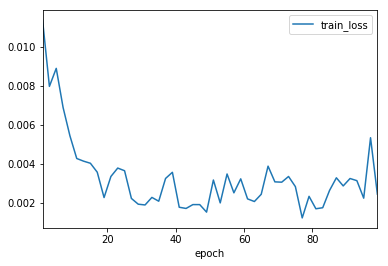

In [7]:
## result graph　
import matplotlib
import matplotlib.pyplot as plt

df = pd.DataFrame({
        'epoch': [x[0] for x in accuracy_results],
        'train_loss': [x[1] for x in accuracy_results]
    })
#        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='train_loss')
df.head()